In [1]:
from lale.datasets.uci.uci_datasets import fetch_drugscom
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
train_X_all, train_y_all, test_X, test_y = fetch_drugscom()
#subset to reduce overfitting and speed up experimentation
train_X, train_X_ignore, train_y, train_y_ignore = train_test_split(
    train_X_all, train_y_all, train_size=0.1, random_state=42)
print(f'shapes: train_X {train_X.shape}, test_X {test_X.shape}')
train_X.head()

shapes: train_X (16129, 5), test_X (53766, 5)


,drugName,condition,review,date,usefulCount
10015,Ethinyl estradiol / etonogestrel,Birth Control,"""I was 18 when I used this. The only problem I...","March 6, 2013",18
60369,Etonogestrel,Birth Control,"""I got the Nexplanon implant back in July 2016...","October 20, 2016",4
35706,Ethinyl estradiol / norgestimate,NaN,"""I have been on this birth control for a few y...","May 22, 2016",1
25223,Hylan g-f 20,Osteoarthritis,"""I had a knee injury over 10 years ago and was...","July 3, 2012",95
144741,Naloxegol,"Constipation, Drug Induced","""Please, please read this before trying any pr...","February 26, 2017",70


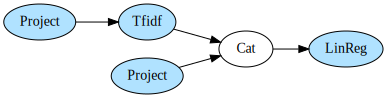

In [2]:
from lale.lib.lale import Project
from lale.lib.lale import ConcatFeatures as Cat
from lale.lib.sklearn import TfidfVectorizer as Tfidf
from lale.lib.sklearn import LinearRegression as LinReg
from lale.helpers import to_graphviz
trainable = (
        Project(columns=['review']) >> Tfidf(max_features=100)
      & Project(columns={'type': 'number'})
    ) >> Cat >> LinReg()
to_graphviz(trainable)

In [3]:
import math
from sklearn.metrics import mean_squared_error
def train_and_test(trainable, label):
    trained = trainable.fit(train_X, train_y)
    predicted = trained.predict(test_X)
    comparisons = [f'{int(test_y[i])}:{predicted[i]:.1f}' for i in range(10)]
    print(f'{label} comparisons [{", ".join(comparisons)}]')
    rmse = math.sqrt(mean_squared_error(predicted, test_y))
    print(f'{label} RMSE {rmse:.2f}')

In [4]:
train_and_test(trainable, 'with Tfidf and LinReg')

with Tfidf and LinReg comparisons [10:7.9, 8:8.9, 9:5.7, 9:8.1, 9:6.1, 4:7.2, 6:5.7, 9:7.9, 7:6.9, 2:5.9]
with Tfidf and LinReg RMSE 2.97


with Tfidf and XGBoost comparisons [10:8.9, 8:8.0, 9:5.8, 9:7.8, 9:5.1, 4:6.8, 6:6.8, 9:7.3, 7:7.8, 2:4.5]
with Tfidf and XGBoost RMSE 2.94


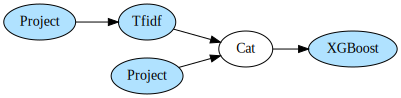

In [5]:
from lale.lib.xgboost import XGBRegressor as XGBoost
trainable = (
        Project(columns=['review']) >> Tfidf(max_features=100)
      & Project(columns={'type': 'number'})
    ) >> Cat >> XGBoost()
train_and_test(trainable, 'with Tfidf and XGBoost')
to_graphviz(trainable)

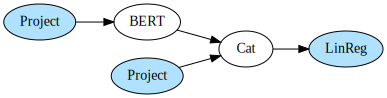

In [6]:
from lale.lib.pytorch import BertPretrainedEncoder as BERT
trainable = (
        Project(columns=['review']) >> BERT(batch_size=126)
      & Project(columns={'type': 'number'})
    ) >> Cat >> LinReg()
if False: #warning, this uses a lot of memory and is slow
    train_and_test(trainable, 'with BERT and LinReg')
to_graphviz(trainable)